In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.base import BaseEstimator, TransformerMixin 

from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from sklearn.decomposition import PCA 
from sklearn.pipeline import Pipeline 
from sklearn.metrics import r2_score
from sklearn import set_config 
from sklearn.model_selection import train_test_split

from plotly import express as px 
from matplotlib import pyplot as plt 
from mlxtend.evaluate import bias_variance_decomp
from IPython.display import display 

import warnings 
sns.set_style('darkgrid')
set_config(display = 'diagram')
warnings.simplefilter('ignore')

In [2]:
concrete = pd.read_csv('ds\Concrete_Data_Yeh.csv')
display(concrete)

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77


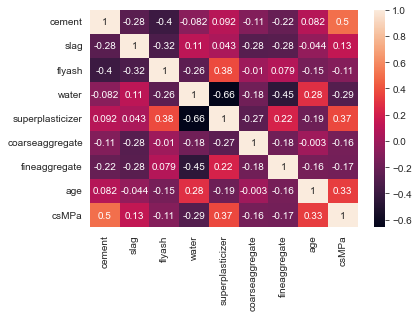

In [3]:
sns.heatmap(
    concrete.corr(), 
    annot = True
)

plt.show()

In [4]:
X, y = concrete.iloc[:, :-1], concrete.csMPa

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size = 0.8, random_state = 0
)

transformer = ColumnTransformer([
    ('transform', PowerTransformer(), slice(0, 9)), 
])

ridge_pipe = Pipeline([
    ('preprocessor', transformer), 
    ('regressor', Ridge(alpha = 10))
])

ridge_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('transform',
                                                  PowerTransformer(),
                                                  slice(0, 9, None))])),
                ('regressor', Ridge(alpha=10))])

In [5]:
ridge_pipe.score(X_test, y_test)

0.824879050064736

In [6]:
reg_pipe = Pipeline([
    ('preprocessor', transformer), 
    ('regressor', LinearRegression())
])

reg_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('transform',
                                                  PowerTransformer(),
                                                  slice(0, 9, None))])),
                ('regressor', LinearRegression())])

In [7]:
reg_pipe.score(X_test, y_test)

0.82537449087674

In [8]:
class RidgeRegressor(BaseEstimator, TransformerMixin):
    
    def __init__(self, alpha = 0.5, epochs = 1000, learning_rate = 0.001):
        self.__name = 'gradient_descent_ridge'
        self.epochs = epochs 
        self.learning_rate = learning_rate
        self.alpha = alpha 
        

    def fit(self, X, y):
        rows, cols = X.shape
        X_, ones = X, np.ones((rows, 1))
        X_ = np.hstack((ones, X_))
        self.W_ = np.ones((cols+1, 1))
       
        for j in range(self.epochs): 
            
            slope = X_.T.dot(X_).dot(self.W_) + self.W_*self.alpha - X_.T.dot(y.values.reshape(-1, 1))
            self.W_ = self.W_ - self.learning_rate*slope 
            

        return self 

    def transform(self, X, y = None):
        return self 
    
    def predict(self, X, y = None):
        rows, cols = X.shape
        X_, ones = X, np.ones((rows, 1))
        X_ = np.hstack((ones, X_))
        print(X_.shape, self.W_.shape)
        return X_.dot(self.W_)
    
    def score(self, X, y):
        rows, cols = X.shape 
        X_, ones = X, np.ones((rows, 1))
        X_ = np.hstack((ones, X_))
        y_preds = X_.dot(self.W_)
        return r2_score(y_preds, y)
    

ridge = RidgeRegressor(alpha = 3, epochs = 1000, learning_rate = 0.0001)

gd_pipe = Pipeline([
    ('preprocessor', transformer), 
    ('regressor', ridge)
])

gd_pipe.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('transform',
                                                  PowerTransformer(),
                                                  slice(0, 9, None))])),
                ('regressor', RidgeRegressor(alpha=3, learning_rate=0.0001))])

In [9]:
gd_pipe.score(X_test, y_test)

0.8057511052099688

In [10]:
pca = PCA(n_components=2)
train_X = transformer.fit_transform(X_train)
df = pca.fit_transform(train_X)
tset = pd.DataFrame(
    np.hstack((df, y_train.values.reshape(-1, 1))),
    columns = ['f1', 'f2', 'target']
) 

px.scatter_3d(data_frame=tset, x = 'f1', y = 'f2', z = 'target')


In [11]:
df.shape

(824, 2)

In [12]:
bias, variance, loss, alphas  = [], [], [], []
coef_df = []
colnames = ['alpha']
test_X = transformer.fit_transform(X_test)

for alpha in np.linspace(0, 11, 150):
    lasso = Lasso(alpha = alpha)

    avg_loss, avg_bias, avg_var = bias_variance_decomp(
        lasso, train_X, y_train.values, test_X, y_test.values, loss = 'mse'
    )
    
    lasso.fit(train_X, y_train)

    coef_df.append(lasso.coef_.tolist()) 
    alphas.append(alpha)
    bias.append(avg_bias)
    loss.append(avg_loss)
    variance.append(avg_var)

    
bias_var_table = pd.DataFrame({
    'bias':bias, 
    'variance':variance, 
    'loss':loss, 
    'lambda':alphas, 
})

colnames += list(concrete.iloc[:, :-1].columns)
coef_table = pd.DataFrame(
    np.hstack((np.array(alphas).reshape(-1, 1), np.array(coef_df))), 
    columns = colnames
)

bias_var_table.set_index('lambda')

display(bias_var_table)


,bias,variance,loss,lambda
0,47.041776,0.761350,47.803126,0.000000
1,46.848096,0.738649,47.586745,0.073826
2,46.783090,0.701947,47.485037,0.147651
3,46.770649,0.661933,47.432582,0.221477
4,46.916533,0.594020,47.510553,0.295302
...,...,...,...,...
145,265.298520,0.320340,265.618860,10.704698
146,265.585643,0.316869,265.902512,10.778523
147,265.276306,0.401288,265.677594,10.852349
148,265.417137,0.304908,265.722045,10.926174


In [13]:
sc = MinMaxScaler()
bias_var_table[['bias', 'variance', 'loss']] = sc.fit_transform(bias_var_table[['bias', 'variance', 'loss']])

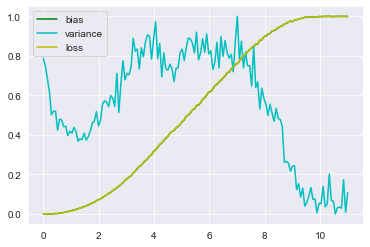

In [14]:
plt.plot(bias_var_table['lambda'], bias_var_table['bias'], '-g', label = 'bias')
plt.plot(bias_var_table['lambda'], bias_var_table['variance'], '-c', label = 'variance')
plt.plot(bias_var_table['lambda'], bias_var_table['loss'], '-y', label = 'loss')
plt.legend()
plt.grid(True)


In [15]:
bias_var_table

,bias,variance,loss,lambda
0,0.001239,0.786767,0.001696,0.000000
1,0.000354,0.748056,0.000706,0.073826
2,0.000057,0.685469,0.000240,0.147651
3,0.000000,0.617232,0.000000,0.221477
4,0.000667,0.501422,0.000357,0.295302
...,...,...,...,...
145,0.998688,0.034717,0.998645,10.704698
146,1.000000,0.028799,0.999943,10.778523
147,0.998586,0.172758,0.998914,10.852349
148,0.999230,0.008400,0.999117,10.926174


In [16]:
lasso_pipe = Pipeline([
    ('column-transformer', transformer), 
    ('lasso-regressor', Lasso(alpha = 1.67))
])

lasso_pipe.fit(X_train, y_train)

Pipeline(steps=[('column-transformer',
                 ColumnTransformer(transformers=[('transform',
                                                  PowerTransformer(),
                                                  slice(0, 9, None))])),
                ('lasso-regressor', Lasso(alpha=1.67))])

In [17]:
lasso_pipe.score(X_test, y_test)

0.778138474647731

In [18]:
coef_table = coef_table.set_index('alpha')

coef_table.head(30)

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age
alpha,,,,,,,,
0.000000,8.834274,5.179094,0.709390,-5.233597,2.293002,-0.527456,-1.553835,10.070497
0.073826,8.737831,5.100920,0.516167,-4.953357,2.514870,-0.360454,-1.398146,9.977495
0.147651,8.635218,5.016403,0.319090,-4.680489,2.734686,-0.199480,-1.248852,9.884605
0.221477,8.531718,4.930955,0.120959,-4.407321,2.955398,-0.038740,-1.099956,9.791633
0.295302,8.420426,4.822438,0.000000,-4.244883,3.050498,-0.000000,-1.011779,9.703834
0.369128,8.356150,4.754363,0.000000,-4.126372,3.038683,-0.000000,-0.921020,9.620904
0.442953,8.292093,4.686359,0.000000,-4.007265,3.027127,-0.000000,-0.829988,9.537931
0.516779,8.227988,4.618342,0.000000,-3.888300,3.015507,-0.000000,-0.739019,9.454970
0.590604,8.163699,4.550264,0.000000,-3.769835,3.003670,-0.000000,-0.648279,9.372043
